In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

## Loading dataset

**Data preparation note:**
The data used in this analysis was extracted from multiple historical projects.
The preprocessing steps (data extraction, cleaning, unification, and normalization) were performed prior to this notebook and are not shown here. This included handling diverse and inconsistent project data, aligning formats, and ensuring uniform feature structure across all entries. What follows assumes the dataset is ready for modeling and analysis.

In [2]:
data = pd.read_csv('./data/doors_data_full.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      3213 non-null   int64  
 1   floor           3213 non-null   object 
 2   door_type       3204 non-null   object 
 3   door_number     3211 non-null   object 
 4   door_leaf       3213 non-null   object 
 5   width           3213 non-null   float64
 6   height          3213 non-null   float64
 7   r_l_opening     3213 non-null   object 
 8   is_escape       3213 non-null   object 
 9   host_width      3213 non-null   float64
 10  host_material   3213 non-null   object 
 11  from_room       3213 non-null   object 
 12  to_room         3213 non-null   object 
 13  from_room_area  3213 non-null   float64
 14  to_room_area    3213 non-null   float64
 15  frame_type      3196 non-null   object 
 16  frame_material  3213 non-null   object 
 17  frame_finish    3199 non-null   o

interval columns not set, guessing: ['Unnamed: 0', 'width', 'height', 'host_width', 'from_room_area', 'to_room_area']


<Figure size 1200x1000 with 0 Axes>

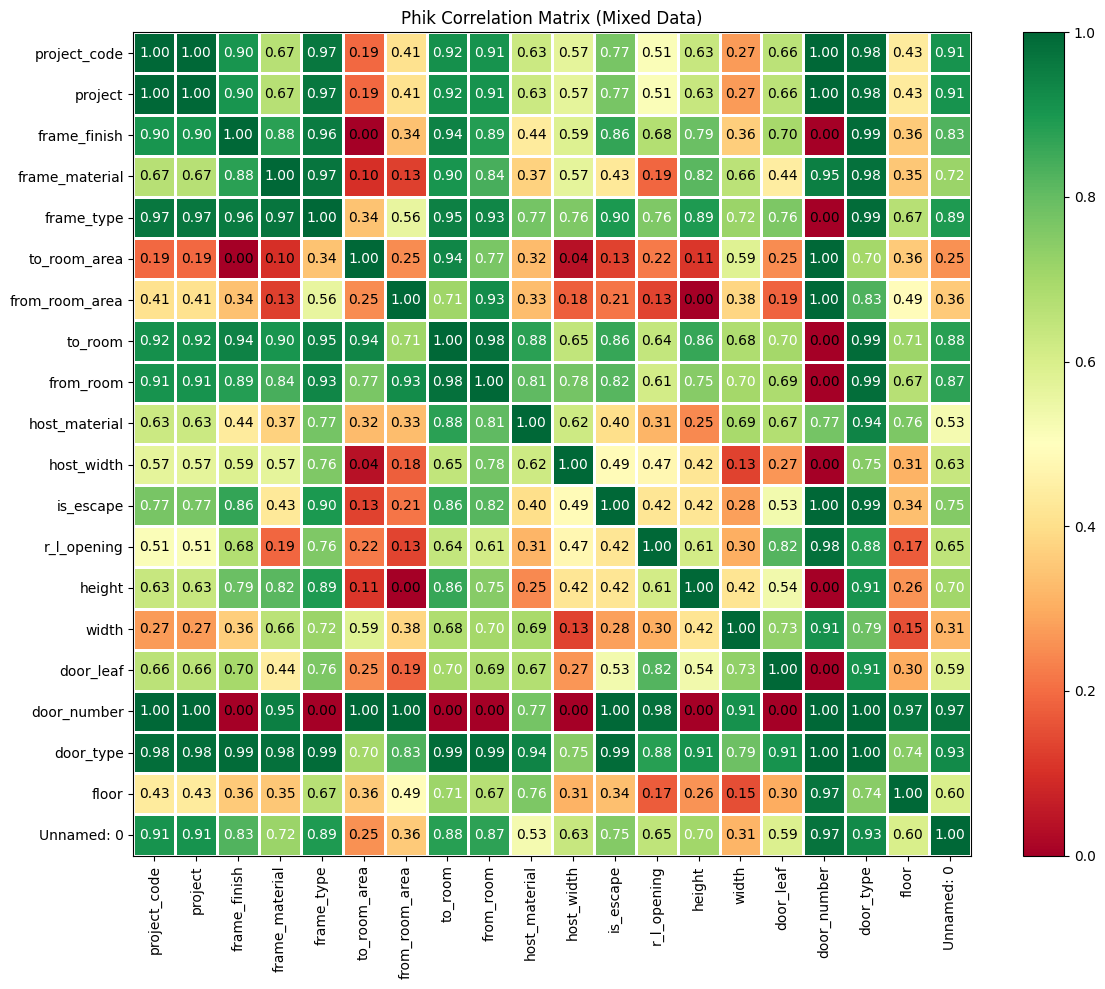

In [3]:
from phik import resources, report
from phik.report import plot_correlation_matrix

phik_matrix = data.phik_matrix()

plt.figure(figsize=(12, 10))
plot_correlation_matrix(phik_matrix.values, 
                        x_labels=phik_matrix.columns, 
                        y_labels=phik_matrix.index, 
                        vmin=0, vmax=1, 
                        figsize=(12, 10))
plt.title("Phik Correlation Matrix (Mixed Data)")
plt.show()

We included only features with a correlation lower then 0.7 with the target to avoid data leakage and overfitting.

## Features selection

### Features for Training

For this experiment, I selected only simple and universally available features that can be reliably extracted from most Revit (RVT) project files. The goal was to use default attributes present in any office building project, to ensure robustness and reproducibility.

Below, we will also analyze which features turned out to be the most and least important for the prediction task.


In [4]:
feature_columns = [
    'floor',
    'door_leaf',
    'width',
    'r_l_opening',
    'host_width',
    'host_material',
    'from_room',
    'to_room',
    'from_room_area',
    'to_room_area'
]

In [5]:
data[feature_columns].head()

,floor,door_leaf,width,r_l_opening,host_width,host_material,from_room,to_room,from_room_area,to_room_area
0,2_UG,1FL,1.32,R,0.30,STB,Parken,Schleuse,3804.75,6.73
1,2_UG,1FL,1.32,R,0.25,STB,Parken,Schleuse,3804.75,8.76
2,2_UG,1FL,1.32,R,0.22,STB,Parken,Schleuse,4049.80,5.14
3,2_UG,1FL,1.32,R,0.30,STB,Parken,Schleuse,4049.80,18.77
4,2_UG,1FL,1.32,R,0.25,STB,Parken,Schleuse,4049.80,12.56


### Target Selection

Picking the target variable was a bit of a challenge. My primary goal in this experiment was to test the overall concept: **can we predict any feature based on data from previous projects**?

To do this, I needed a target that was present and sufficiently unified across all available projects. Since these projects were completed in different years and under different standards, it was difficult to use something like the "family type" (which would make more sense from a BIM or architectural perspective). Ultimately, I chose to predict the **door frame material**, as it was consistently available and reasonably standardized in the datasets.

In [6]:
X = data[feature_columns].columns
y = ['frame_material']

### Approach: Tabular Data and Classical ML

In this project, we are working with simple tabular data and applying classical machine learning models. Since the performance of such models strongly depends on the quality and relevance of input features, careful feature selection and tuning is especially important at each stage of the workflow.

### Categorical data 

In [7]:
categorical = [
    'floor',
    'door_leaf',
    'r_l_opening',
    'host_material',
    'from_room',
    'to_room'
]

### Picking office buildings out of df

In [8]:
data['project_code'].value_counts()

project_code
mixed_2     889
office_2    770
office_5    554
office_1    323
office_3    299
office_4    257
mixed_1     121
Name: count, dtype: int64

## Train - office_1, office_2, office_3, office_4

The training set consists of data from four different office buildings. The idea is to train the models on these diverse projects and then test their ability to generalize by making predictions on a completely separate, fifth office building that was not seen during training.

This setup simulates a real-world scenario where we want to predict parameters for a new building using knowledge accumulated from previous, unrelated projects.


In [9]:
office_train = data[(data['project_code']=='office_1') |
             (data['project_code']=='office_2') |
             (data['project_code']=='office_3') |
             (data['project_code']=='office_4')]

#### Projects distribution

This cell shows the distribution of training samples across the four office buildings. Note that the projects are not equally represented: *office_2* dominates the dataset, while *office_4* is the smallest group. This kind of imbalance can affect model performance and should be kept in mind when interpreting the results.

In [10]:
office_train['project_code'].value_counts()

project_code
office_2    770
office_1    323
office_3    299
office_4    257
Name: count, dtype: int64

#### Train - target data balance

Here we see the class balance for the target variable `frame_material` in the training data. There is a strong class imbalance: the majority of samples belong to class `S`, while the other materials, especially `H` and `gD`, are much less common. This is a typical real-world situation and it can make it harder for models to correctly predict rare classes.

In [11]:
office_train['frame_material'].value_counts()

frame_material
S     1189
A      366
H       49
gD      45
Name: count, dtype: int64

## Train, val

In [12]:
train, val = train_test_split(office_train,
                            train_size=0.8,
                            random_state=42,
                            stratify=office_train['frame_material'])
print(val.shape)
print(train.shape)

(330, 20)
(1319, 20)


## Test - office_5

For testing, I use data from the fifth building (*office_5*), which was completely excluded from the training process. This setup allows us to evaluate how well the model generalizes to a new project that it has never seen before—closely simulating real-life scenarios where a model is applied to new buildings.

In [13]:
test = data[data['project_code']=='office_5']

### Test - target data balance

In [14]:
test['frame_material'].value_counts()

frame_material
S    458
A     96
Name: count, dtype: int64

### Train-Test check

In [15]:
train[X].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1319 entries, 1026 to 2173
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   floor           1319 non-null   object 
 1   door_leaf       1319 non-null   object 
 2   width           1319 non-null   float64
 3   r_l_opening     1319 non-null   object 
 4   host_width      1319 non-null   float64
 5   host_material   1319 non-null   object 
 6   from_room       1319 non-null   object 
 7   to_room         1319 non-null   object 
 8   from_room_area  1319 non-null   float64
 9   to_room_area    1319 non-null   float64
dtypes: float64(4), object(6)
memory usage: 113.4+ KB


In [16]:
train[y].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1319 entries, 1026 to 2173
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   frame_material  1319 non-null   object
dtypes: object(1)
memory usage: 20.6+ KB


## Catboost

CatBoost is a gradient boosting algorithm developed specifically to handle categorical features efficiently, making it ideal for our dataset, which contains many categorical variables (such as floor, door type, and material). It requires minimal preprocessing for categorical columns and is known for its strong performance, fast training, and robustness to overfitting.  
In this notebook, CatBoost is used as one of the main models to demonstrate its practical advantages on real-world construction data.

In [17]:
params_office_5 = {'verbose':100,
               'random_seed':42,
               'cat_features': categorical,
               'learning_rate':0.15}

In [18]:
model_catboost = CatBoostClassifier(**params_office_5)

In [19]:
model_catboost.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 1.1268789	test: 1.1246572	best: 1.1246572 (0)	total: 199ms	remaining: 3m 18s
100:	learn: 0.0496087	test: 0.0771084	best: 0.0771084 (100)	total: 8.67s	remaining: 1m 17s
200:	learn: 0.0266422	test: 0.0613318	best: 0.0609369 (196)	total: 17.3s	remaining: 1m 8s
300:	learn: 0.0165156	test: 0.0568303	best: 0.0564957 (292)	total: 25.5s	remaining: 59.2s
400:	learn: 0.0112896	test: 0.0541617	best: 0.0537526 (388)	total: 33.8s	remaining: 50.5s
500:	learn: 0.0084445	test: 0.0543032	best: 0.0532435 (426)	total: 41.9s	remaining: 41.7s
600:	learn: 0.0069652	test: 0.0538637	best: 0.0532435 (426)	total: 50.2s	remaining: 33.4s
700:	learn: 0.0057679	test: 0.0535688	best: 0.0532435 (426)	total: 58.6s	remaining: 25s
800:	learn: 0.0048906	test: 0.0523796	best: 0.0521049 (786)	total: 1m 6s	remaining: 16.6s
900:	learn: 0.0042482	test: 0.0528013	best: 0.0521049 (786)	total: 1m 15s	remaining: 8.27s
999:	learn: 0.0037047	test: 0.0535606	best: 0.0521049 (786)	total: 1m 23s	remaining: 0us

bestTest = 0.

### Feature Importance

The table below shows the importance of each feature as estimated by CatBoost. Feature importance helps us understand which parameters have the strongest influence on the prediction of door frame material. In this case, **height** and **width** are the most influential factors, while parameters like `from_room`, `host_material`, and `to_room` also contribute significantly. Less important features (like `r_l_opening` or room areas) have a smaller impact on model decisions.  
This ranking can help prioritize which building parameters are most critical for similar prediction tasks or future data collection.


In [20]:
model_catboost.get_feature_importance(prettified=True)

,Feature Id,Importances
0,width,22.681919
1,floor,12.120722
2,host_material,11.633917
3,from_room,11.599162
4,to_room,10.731020
5,door_leaf,10.457846
6,host_width,8.307698
7,to_room_area,4.972325
8,from_room_area,3.836197
9,r_l_opening,3.659194


### Catboost Prediction

In [21]:
test['prediction_frame_material_catboost'] = model_catboost.predict(test[X]).ravel()

In [22]:
test[['frame_material', 'prediction_frame_material_catboost', 'project_code']]

,frame_material,prediction_frame_material_catboost,project_code
1093,S,S,office_5
1094,S,S,office_5
1095,S,S,office_5
1096,S,S,office_5
1097,S,S,office_5
...,...,...,...
1642,S,S,office_5
1643,S,S,office_5
1644,S,S,office_5
1645,S,S,office_5


In [23]:
test['prediction_frame_material_catboost'].value_counts()

prediction_frame_material_catboost
S    455
A     99
Name: count, dtype: int64

### Number of mismatches

In [24]:
mismatch_count_tam5 = (test['prediction_frame_material_catboost'] != test['frame_material']).sum()
score_tam5 = round(mismatch_count_tam5/len(test)*100, 2)
print(f'{100 - round(mismatch_count_tam5/len(test)*100, 2)}% of predictions are correct,\
while using train data = {len(train)}')

96.21% of predictions are correct,while using train data = 1319


### F1 score

In [25]:
f1_score(test['frame_material'], test['prediction_frame_material_catboost'], average='macro')

0.9346532985087201

### Confusion matrix for Catboost prediction

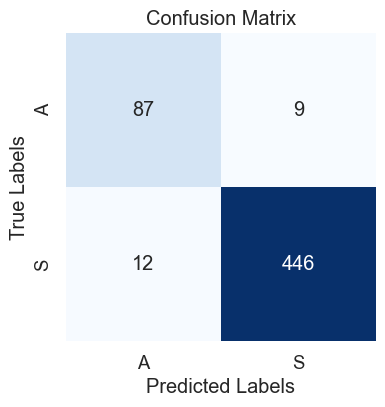

In [26]:
conf_matrix = confusion_matrix(test['frame_material'],
                               test['prediction_frame_material_catboost'])

plt.figure(figsize=(4, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["A", "S"],
            yticklabels=["A", "S"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix shows that the CatBoost model performs well overall, with most predictions for both classes (“A” and “S”) being correct. However, there are a small number of misclassifications between the two classes: 9 samples of “A” are predicted as “S”, and 12 samples of “S” are predicted as “A”. This indicates the model distinguishes well between classes, but there is still some overlap, which may be related to the feature similarity or data noise. The performance for the majority class (“S”) is slightly better, which is typical in imbalanced datasets.

## LightGBM

In [27]:
for col in categorical:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    val[col] = val[col].astype('category')

val[categorical].info()

<class 'pandas.core.frame.DataFrame'>
Index: 330 entries, 777 to 89
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   floor          330 non-null    category
 1   door_leaf      330 non-null    category
 2   r_l_opening    330 non-null    category
 3   host_material  330 non-null    category
 4   from_room      330 non-null    category
 5   to_room        330 non-null    category
dtypes: category(6)
memory usage: 10.7 KB


Randomized Search (RandomizedSearchCV) is a practical and efficient approach for hyperparameter tuning, especially when the search space is large or some parameters are not well understood. Instead of exhaustively trying all possible combinations like GridSearch, it samples a fixed number of parameter settings from specified distributions. This allows you to explore a wide range of hyperparameter values while saving computational time and resources. Random search often finds good or even optimal configurations faster than grid search and is generally recommended as a first step in model optimization.

In [28]:
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9, 12],
    'num_leaves': [15, 31, 63, 127],
    'min_child_samples': [10, 20, 30, 50],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'class_weight': ['balanced', None],
    'reg_alpha': [0.0, 0.01, 0.1, 1.0],
    'reg_lambda': [0.0, 0.01, 0.1, 1.0],
}

rand = RandomizedSearchCV(
    LGBMClassifier(categorical_feature=categorical, random_state=42, verbose=-1),
    param_distributions=param_grid,
    n_iter=40,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42
)
rand.fit(train[X], train[y].values.ravel())
print("Best params:", rand.best_params_)
print("Best CV score:", rand.best_score_)

Best params: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'num_leaves': 127, 'n_estimators': 400, 'min_child_samples': 10, 'max_depth': 9, 'learning_rate': 0.03, 'colsample_bytree': 0.9, 'class_weight': None}
Best CV score: 0.9697291584170626


In [29]:
model_lgbm = LGBMClassifier(**rand.best_params_)
model_lgbm.fit(train[X],train[y].values.ravel() ,eval_set=[(val[X],val[y].values.ravel())])

LGBMClassifier(colsample_bytree=0.9, learning_rate=0.03, max_depth=9,
               min_child_samples=10, n_estimators=400, num_leaves=127,
               reg_lambda=1.0)

In [30]:
feature_importances = model_lgbm.feature_importances_
feature_names = model_lgbm.feature_name_
df_feature_importances = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance (Split)': feature_importances
})
df_feature_importances = df_feature_importances.sort_values(by='Importance (Split)', ascending=False).reset_index(drop=True)

total_importance = df_feature_importances['Importance (Split)'].sum()
df_feature_importances['Importance (%)'] = (df_feature_importances['Importance (Split)'] / total_importance) * 100

df_feature_importances

,Feature Name,Importance (Split),Importance (%)
0,width,5786,24.508641
1,to_room_area,5766,24.423924
2,from_room_area,5417,22.945612
3,host_width,4968,21.043714
4,r_l_opening,902,3.820739
5,to_room,307,1.300407
6,from_room,239,1.012369
7,floor,204,0.864114
8,door_leaf,18,0.076245
9,host_material,1,0.004236


### LightGBM Prediction 

In [31]:
test['prediction_frame_material_lgbm'] = model_lgbm.predict(test[X]).ravel()

In [32]:
test[['frame_material', 'prediction_frame_material_catboost', 'prediction_frame_material_lgbm', 'project_code']]

,frame_material,prediction_frame_material_catboost,prediction_frame_material_lgbm,project_code
1093,S,S,S,office_5
1094,S,S,S,office_5
1095,S,S,S,office_5
1096,S,S,S,office_5
1097,S,S,S,office_5
...,...,...,...,...
1642,S,S,S,office_5
1643,S,S,S,office_5
1644,S,S,S,office_5
1645,S,S,S,office_5


In [33]:
test['prediction_frame_material_lgbm'].value_counts()

prediction_frame_material_lgbm
S    488
A     66
Name: count, dtype: int64

### Number of mismatches

In [34]:
mismatch_count_tam5 = (test['prediction_frame_material_lgbm'] != test['frame_material']).sum()
score_tam5 = round(mismatch_count_tam5/len(test)*100, 2)
print(f'{100 - round(mismatch_count_tam5/len(test)*100, 2)}% of predictions are correct, \
while using train data = {len(train)}')

91.34% of predictions are correct, while using train data = 1319


### F1 score

In [35]:
f1_score(test['frame_material'], test['prediction_frame_material_lgbm'], average='macro')

0.8264818729935008

### Confusion matrix LightGBM

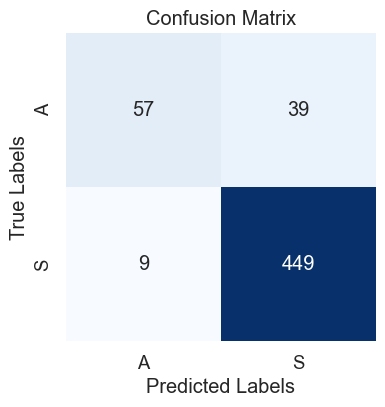

In [36]:
conf_matrix = confusion_matrix(test['frame_material'],
                               test['prediction_frame_material_lgbm'])

plt.figure(figsize=(4, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["A", "S"],
            yticklabels=["A", "S"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix for LightGBM shows that the model tends to over-predict the 'S' class at the expense of the 'A' class. While it correctly classifies most of the 'S' samples (449 out of 458), it struggles with the 'A' class, misclassifying 39 out of 96 'A' instances as 'S'. This suggests that the model may be biased toward the majority class or not capturing enough signal to separate 'A' from 'S'. Further tuning or data balancing techniques may be needed to improve recall for the minority class.


## RandomForestClassifier

### OneHotEncoder

In [37]:
ohe_features = office_train[X].select_dtypes(include='object').columns.to_list()
print(ohe_features)
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

column_transformer = ColumnTransformer(
    transformers=[('encoder', encoder_ohe, ohe_features)],
    remainder='passthrough'
)

column_transformer.fit(office_train[X])
X_office_train_ohe = column_transformer.transform(office_train[X])
X_test_ohe = column_transformer.transform(test[X])

['floor', 'door_leaf', 'r_l_opening', 'host_material', 'from_room', 'to_room']


We also add a Random Forest model for comparison. Since Random Forests do not natively handle categorical features, we’ll use one-hot encoding (OHE) for the relevant columns before training the model.

### Model

In [38]:
params_office_5 = {'n_estimators': 150,
               'min_samples_split': 10,
               'class_weight':'balanced',
               'max_features': 'log2',
               'max_depth': 15,
               'random_state': 42}

In [39]:
model_rfc = RandomForestClassifier(**params_office_5)

In [40]:
model_rfc.fit(X_office_train_ohe, office_train[y].values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features='log2', min_samples_split=10,
                       n_estimators=150, random_state=42)

### Prediction RandomForest

In [41]:
test['prediction_frame_material_rfc'] = model_rfc.predict(X_test_ohe).ravel()
test[['frame_material', 'prediction_frame_material_catboost', 'prediction_frame_material_lgbm','prediction_frame_material_rfc', 'project_code']]

,frame_material,prediction_frame_material_catboost,prediction_frame_material_lgbm,prediction_frame_material_rfc,project_code
1093,S,S,S,S,office_5
1094,S,S,S,A,office_5
1095,S,S,S,S,office_5
1096,S,S,S,S,office_5
1097,S,S,S,S,office_5
...,...,...,...,...,...
1642,S,S,S,S,office_5
1643,S,S,S,S,office_5
1644,S,S,S,S,office_5
1645,S,S,S,S,office_5


In [42]:
test['prediction_frame_material_rfc'].value_counts()

prediction_frame_material_rfc
S    459
A     95
Name: count, dtype: int64

### Number of mismatches

In [43]:
mismatch_count_tam5 = (test['prediction_frame_material_rfc'] != test['frame_material']).sum()
score_tam5 = round(mismatch_count_tam5/len(test)*100, 2)
print(f'{100 - round(mismatch_count_tam5/len(test)*100, 2)}% of predictions are correct, \
while using train data = {len(train)}')

93.68% of predictions are correct, while using train data = 1319


### F1 score

In [44]:
f1_score(test['frame_material'], test['prediction_frame_material_rfc'], average='macro')

0.8892929938851365

### Confusion matrix RandomForest

[[ 78  18]
 [ 17 441]]


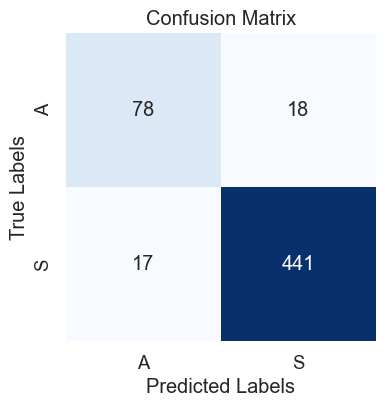

In [45]:
conf_matrix = confusion_matrix(test['frame_material'],
                               test['prediction_frame_material_rfc'])
print(conf_matrix)
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["A", "S"],
            yticklabels=["A", "S"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix for the Random Forest model shows that most predictions are correct, especially for class "S" (441 out of 458). However, the model confuses some samples of class "A" with "S" (18 times) and vice versa (17 times). This suggests that while Random Forest performs quite well overall, it tends to misclassify a portion of "A" samples as "S" and vice versa, indicating the classes are somewhat challenging to separate for this model.

## Compare all results

In [46]:
test[['frame_material', 'prediction_frame_material_catboost', 'prediction_frame_material_lgbm','prediction_frame_material_rfc', 'project_code']]

,frame_material,prediction_frame_material_catboost,prediction_frame_material_lgbm,prediction_frame_material_rfc,project_code
1093,S,S,S,S,office_5
1094,S,S,S,A,office_5
1095,S,S,S,S,office_5
1096,S,S,S,S,office_5
1097,S,S,S,S,office_5
...,...,...,...,...,...
1642,S,S,S,S,office_5
1643,S,S,S,S,office_5
1644,S,S,S,S,office_5
1645,S,S,S,S,office_5


In [47]:
len(test[
    (test['prediction_frame_material_catboost'] == test['prediction_frame_material_lgbm']) &
    (test['prediction_frame_material_catboost'] == test['prediction_frame_material_rfc'])
    ])

505

In [48]:
test[
    (test['prediction_frame_material_catboost'] == test['prediction_frame_material_lgbm']) &
    (test['prediction_frame_material_catboost'] == test['prediction_frame_material_rfc']) &
    (test['frame_material'] != test['prediction_frame_material_rfc'])
    ]

,Unnamed: 0,floor,door_type,door_number,door_leaf,width,height,r_l_opening,is_escape,host_width,...,from_room_area,to_room_area,frame_type,frame_material,frame_finish,project,project_code,prediction_frame_material_catboost,prediction_frame_material_lgbm,prediction_frame_material_rfc
1181,1663,EG,unknown,100-430.1,1FL,1.385,2.26,R,unknown,0.175,...,70.21,28.36,-,A,unknown,tam5,office_5,S,S,S
1217,1699,EG,unknown,100-581.2,1FL,3.675,2.35,empty,unknown,0.050,...,322.98,96.79,-,S,unknown,tam5,office_5,A,A,A
1218,1700,EG,unknown,100-581.3,1FL,5.350,2.35,empty,unknown,0.050,...,322.98,96.79,-,S,unknown,tam5,office_5,A,A,A
1262,1745,EG,unknown,100-985.1,2FL,2.010,2.01,L,unknown,0.175,...,32.13,49.38,EZ,S,unknown,tam5,office_5,A,A,A
1269,1752,EG,unknown,100-991.1,1FL,1.190,2.42,L,unknown,0.300,...,12.38,0.00,-,A,unknown,tam5,office_5,S,S,S
1275,1759,EG,unknown,101-037.2,3FL,1.350,4.35,R/L,unknown,0.025,...,0.00,0.00,-,A,unknown,tam5,office_5,S,S,S
1277,1761,EG,unknown,101-039.1,2FL,3.010,3.26,R,unknown,0.240,...,0.00,0.00,UZ-SN,S,unknown,tam5,office_5,A,A,A
1287,1771,EG,unknown,101-261.1,2FL,3.010,3.26,R,unknown,0.240,...,0.00,0.00,UZ-SN,S,unknown,tam5,office_5,A,A,A
1295,1779,EG,unknown,101-500.3,1FL,1.760,2.76,R,unknown,0.155,...,0.00,161.33,-,A,unknown,tam5,office_5,S,S,S
1306,1790,EG,unknown,101-533.1,1FL,1.385,2.26,L,unknown,0.240,...,79.17,144.49,UZ-SN,S,unknown,tam5,office_5,A,A,A


In [49]:
len(test[
    (test['prediction_frame_material_catboost'] == test['prediction_frame_material_lgbm']) &
    (test['prediction_frame_material_catboost'] == test['prediction_frame_material_rfc']) &
    (test['frame_material'] == test['prediction_frame_material_rfc'])
    ])

489

## Final Report

In [50]:
uncorrect_prediction_by_3_models = ((test['prediction_frame_material_catboost'] != test['frame_material']) &
                            (test['prediction_frame_material_lgbm'] != test['frame_material']) &
                            (test['prediction_frame_material_rfc'] != test['frame_material'])).sum()

print(f'uncorrect predictions by 3 models = {uncorrect_prediction_by_3_models}')

mismatch_by_three_models = ((test['prediction_frame_material_catboost'] != test['frame_material']) |
                            (test['prediction_frame_material_lgbm'] != test['frame_material']) |
                            (test['prediction_frame_material_rfc'] != test['frame_material'])).sum()

print(f'total mismatches by 3 models = {mismatch_by_three_models}')

score_tam5_by_three_models = round(mismatch_by_three_models / len(test) * 100, 2)
print(f'{100 - score_tam5_by_three_models}% of predictions are correct, \
from total test data of size {len(test)}')
print(f'train data = {len(office_train)}, where train = {len(train)}, val = {len(val)}')

uncorrect predictions by 3 models = 16
total mismatches by 3 models = 65
88.27% of predictions are correct, from total test data of size 554
train data = 1649, where train = 1319, val = 330


## Voting

In [51]:
pred1 = model_catboost.predict(test[X]).ravel()
pred2 = model_lgbm.predict(test[X]).ravel()
pred3 = model_rfc.predict(X_test_ohe).ravel()

all_preds = np.vstack([pred1, pred2, pred3]).T

def row_mode(arr):
    vals, counts = np.unique(arr, return_counts=True)
    return vals[np.argmax(counts)]

final_pred = np.apply_along_axis(row_mode, axis=1, arr=all_preds)

test['final_pred'] = final_pred

In [52]:
len(test[test['frame_material'] == test['final_pred']])

531

In [73]:
proba_cat = model_catboost.predict_proba(test[X])
proba_lgbm = model_lgbm.predict_proba(test[X])
proba_rfc = model_rfc.predict_proba(X_test_ohe)

mean_proba = (proba_cat + proba_lgbm + proba_rfc) / 3

final_pred = mean_proba.argmax(axis=1)

class_labels = model_catboost.classes_ 

test['final_pred'] = class_labels[final_pred]
max_mean_proba = mean_proba.max(axis=1)
test['mean_pred_proba'] = max_mean_proba

confident_preds = test[test['mean_pred_proba'] >= 0.85]

confident_preds[['final_pred', 'mean_pred_proba', 'frame_material'] + list(X)].head()


,final_pred,mean_pred_proba,frame_material,floor,door_leaf,width,r_l_opening,host_width,host_material,from_room,to_room,from_room_area,to_room_area
1093,S,0.920996,S,2_UG,1FL,1.010,L,0.250,STB,Schleuse,Lager,10.28,10.88
1095,S,0.916047,S,2_UG,1FL,1.135,R,0.250,STB,Schleuse,TRH,9.48,26.19
1096,S,0.907816,S,2_UG,1FL,1.135,L,0.250,STB,Tiefgarage,Schleuse,1731.49,9.48
1097,S,0.912431,S,2_UG,1FL,1.135,R,0.250,STB,Schleuse,TRH,11.07,33.02
1098,S,0.920805,S,2_UG,1FL,1.135,R,0.175,MWK,Tiefgarage,Schleuse,1731.49,11.07


In [72]:
confident_preds[confident_preds['final_pred'] == confident_preds['frame_material']][['final_pred', 'mean_pred_proba', 'frame_material']]

,final_pred,mean_pred_proba,frame_material
1093,S,0.920996,S
1095,S,0.916047,S
1096,S,0.907816,S
1097,S,0.912431,S
1098,S,0.920805,S
...,...,...,...
1629,S,0.905621,S
1631,S,0.909692,S
1632,S,0.909858,S
1633,S,0.908153,S


### Voting Classifier Results and Next Steps

Here, we combine the predictions of all three models (CatBoost, LightGBM, and RandomForest) using a simple majority voting approach, as well as averaging their predicted probabilities. This technique can help compensate for the individual weaknesses of each model and provides a more robust prediction, especially when the models are diverse and have different error patterns.

The results show that even with a simple ensemble of classical models, it is possible to achieve strong performance on a real-world task, provided the data is properly preprocessed and the workflow is carefully constructed.

**What could be improved and done next?**
- **Get more data:** The most effective way to boost any machine learning model is to increase the diversity and size of your dataset. More projects, different years, and more variety in target values will help models generalize better.
- **Model tuning:** Although classical models are powerful, their performance depends heavily on hyperparameter tuning. Applying techniques like RandomizedSearchCV or Optuna for automated hyperparameter search could further improve results.
- **Feature engineering:** Domain-specific features, more careful handling of categorical variables, and possibly dropping features that leak target information may improve model reliability.
- **Pick an ensemble architecture:** Try stacking (meta-models), weighted voting, or blending to see if more sophisticated ensembles outperform simple voting.
- **Validate with real-world data:** After building your workflow, always check its performance on truly unseen or new-project data to ensure real applicability.
- **Pipeline and deployment:** Consider wrapping your solution into a reproducible pipeline, so it could be re-trained and applied to new datasets in production.

> **This notebook is a demonstration of the concept: with good preprocessing and a thoughtful baseline workflow, even simple tabular models can provide actionable predictions in real BIM or construction data tasks. However, for production or business-critical use, data and model management should be even more rigorous.**
